In [1]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
import os
import numpy as np
import scipy
import scipy.ndimage

sys.path.append('/Users/Michael_Saha/Repositories/blahb')
sys.path.append('/home/paul/Repositories/blahb')
import blahb

from matplotlib.pyplot import *
%matplotlib inline
import numba
sys.path.append('/Users/Michael_Saha/Repositories/')
sys.path.append('./../../../')
from fire_sim import *

import shapefile

In [2]:
shpfile = '/Users/Michael_Saha/DATA/FotF/burn_perims_new/fire_burn_hist_proj2.shp'
shpfile = 'F:/DATA/FotF/burn_perims_new/fire_burn_hist_proj2.shp'
shpfile = '/media/paul/Paul/DATA/FotF/burn_perims_new/fire_burn_hist_proj2.shp'

sf = shapefile.Reader(shpfile)

In [3]:
def read_fire_history(path_to_fire_perims, global_offset_pixels=(0, 0)):
    """
    Arguments:
        path_to_fire_perims - str
            Location of the shapefile with the historical fires in it
        
        global_offset_meters - 2 - tuple
            Offset in meters of our
    Returns:
        List of tuples, each with the following elements:
            [0] - Blob
                A 
            [1] - Info
    
    NOTES:
        pyshp (available with pip from pyPI is needed to read the shapefile)
    """
    import os, blahb, shapefile
    assert os.path.exists(path_to_fire_perims)
    
    sf = shapefile.Reader(path_to_fire_perims)
    
    fires = []
    count = 0
    for i in range(len(sf.shapes())):
        year = int(sf.record(i)[0])
        if year < 2000:
            continue
        shp = sf.shape(i)
        x, y = zip(*shp.points)
        x = (np.array(x)/10).astype(int) - global_offset_pixels[1]
        y = (np.array(y)/10).astype(int) - global_offset_pixels[0]
        
        fire = blahb.polygon2d(y, x, filled=True)
        fire.encode({1})
        fires.append(fire)
    return fires

In [185]:
ss = sf.shape(i)
ss.parts

[0]

In [193]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['YEAR_', 'C', 4, 0],
 ['UNIT_ID', 'C', 3, 0],
 ['FIRE_NUM', 'C', 8, 0],
 ['FIRE_NAME', 'C', 34, 0],
 ['ALARM_DATE', 'N', 10, 0],
 ['CONT_DATE', 'N', 10, 0],
 ['C_METHOD', 'N', 5, 0],
 ['INC_NUM', 'C', 8, 0],
 ['UNIQUE_ID', 'C', 17, 0],
 ['OBJECTIVE', 'N', 5, 0],
 ['COST', 'N', 10, 0],
 ['COMMENTS', 'C', 80, 0],
 ['REPORT_AC', 'N', 19, 8],
 ['GIS_ACRES', 'N', 19, 8],
 ['SHAPE_LENG', 'N', 19, 8],
 ['AGENCY_MAT', 'C', 3, 0],
 ['CAUSECODE', 'N', 19, 8],
 ['CAUSE', 'C', 25, 0],
 ['PERIMETER', 'N', 19, 8],
 ['ACRES_CALC', 'N', 19, 8],
 ['DAY_', 'N', 19, 8],
 ['MONTH_', 'N', 19, 8],
 ['SHAPE_AREA', 'F', 19, 11],
 ['SHAPE_LEN', 'F', 19, 11]]

In [190]:
sf.record(26)

['2002',
 'MVU',
 '00000777',
 'PINES',
 20020729,
 20020811,
 2,
 '00005658',
 '2002CAMVU00000777',
 1,
 0,
 b'                                                                                ',
 61690.0,
 61691.0,
 193363.898085,
 'CDF',
 11.0,
 'Powerline',
 634374.49210768,
 61686.29086814,
 29.0,
 7.0,
 '2.68705483022e+009',
 '6.34374492108e+005']

In [197]:
sf.shape(i).parts

[0, 1155, 1173]

29

In [188]:
for i in range(30):
    print(sf.shape(i).parts)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1155, 1173]


In [4]:
# Get a list of fires
fires = read_fire_history(shpfile)

In [130]:
i = 0

In [176]:
multi_fires = [18,26,36,40]

40


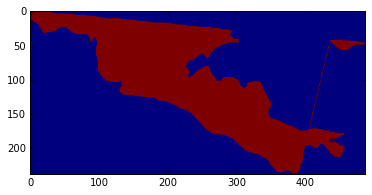

In [175]:
print(i)
f = fires[i]
imshow(f.img)

i += 1

In [204]:
sf.shape(26).parts

[0]

In [118]:
# skeletonize the data to infer ignition pixel
def centroid(blob, astype=float):
    return np.array([np.mean(blob[0].expanded()),
                     np.mean(blob[1].expanded())]).astype(astype)

def skeletonize(blob):
    """Return the skeleton pixels of the blob."""
    from skimage.morphology import medial_axis
    ma = medial_axis(blob.img)
    y, x = np.where(ma)
    return y + blob.offset[0], x + blob.offset[1]

def estimate_ignition_point(blob):
    """Infer ignition point of fire as closest to medial axis point to centroid."""
    yc, xc = centroid(blob, astype=int)
    ys, xs = skeletonize(blob)
    
    dy, dx = ys - yc, xs - xc
    
    closest_idx = np.argmin((dy * dy) + (dx * dx))
    return np.array([ys[closest_idx], xs[closest_idx]])

In [119]:
estimate_ignition_point(f).astype(int)

array([366338,  52800])

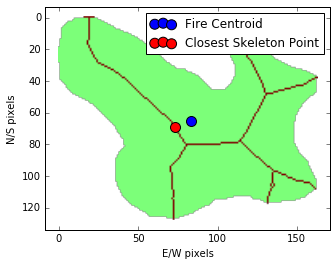

In [128]:
fig = figure()

f = fires[2]

fimg = f.img.astype(float).copy()
fimg[fimg<=0] = np.nan

ma = medial_axis(f.img)
fimg += (ma.astype(int) * 3)

imshow(fimg)
clim(-1,3)

yc, xc = centroid(f) - f.offset
scatter(xc, yc, s=100)

ign = estimate_ignition_point(f)-f.offset

scatter(ign[1], ign[0], s=100, c='r')
ylabel('N/S pixels')
xlabel('E/W pixels')
legend(['Fire Centroid', 'Closest Skeleton Point'])
gcf().savefig('/home/paul/Desktop/ignition.png', dpi=300)

In [74]:
%%time
for f in fires:
    estimate_ignition_point(f)

CPU times: user 35.6 s, sys: 672 ms, total: 36.3 s
Wall time: 36.3 s


In [10]:
centroid(fires[0])

(368923.26612903224, 48718.943548387098)

In [11]:
all_fires = blahb.union(*fires)

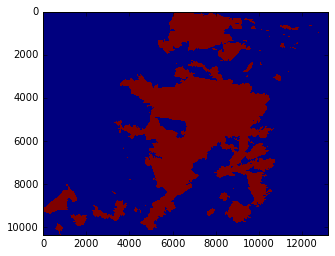

In [42]:
imshow(all_fires.img)

In [12]:
from skimage.morphology import medial_axis

In [28]:
f = fires[2]
fimg = f.img.astype(int)

fimg += medial_axis(fimg)

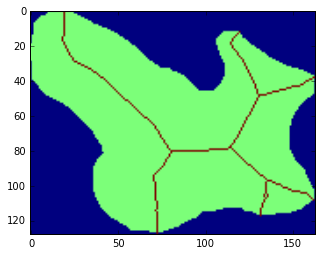

In [29]:
imshow(fimg)

In [27]:
fimg.dtype

dtype('bool')

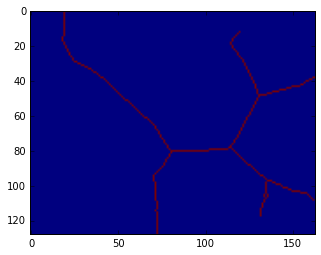

In [18]:
imshow(medial_axis(f.img))

In [196]:
import fiona
f_ign = fiona.open(shpfile)

ImportError: libgeos-3.4.2.so: cannot open shared object file: No such file or directory

In [4]:
shapes = list(sf.shapes())
print(len(shapes))

1412


In [5]:
global_offset = (36000)

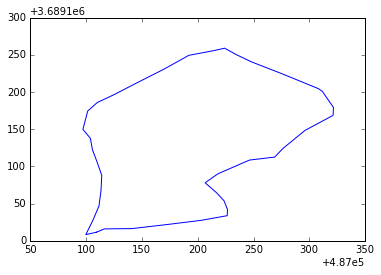

In [6]:
s = shapes[0]
plot(*zip(*s.points))

In [7]:
#imshow(blahb.polygon2d(y,x, filled=True).img)

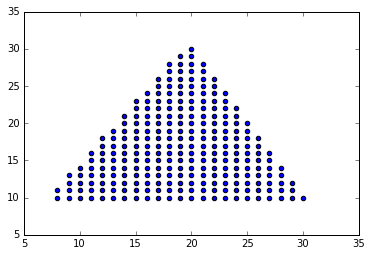

In [9]:
p = blahb.polygon2d([8,20,30], [10,30,10])
scatter(*p)

In [21]:
sys.path.append('/Users/Michael_Saha/Repositories/blahb')
import blahb
import shapefile

#shpfile = '/Users/Michael_Saha/DATA/FotF/burn_perims_new/fire_burn_hist_proj2.shp'
#shpfile = 'F:/DATA/FotF/burn_perims_new/fire_burn_hist_proj2.shp'
sf = shapefile.Reader(shpfile)

fires = []
count = 0
for i in range(len(sf.shapes())):
    year = int(sf.record(i)[0])
    if year < 2000:
        continue
    shp = sf.shape(i)
    x, y = zip(*shp.points)
    x, y = (np.array(x)/10).astype(int), (np.array(y)/10).astype(int)
    
    fire = blahb.polygon2d(y, x, filled=True)
    fire.encode({1})
    #fire.encode(1)
    
    fires.append(fire)

In [23]:
len(fires)

1412

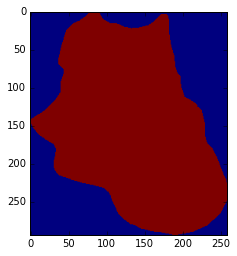

In [24]:
imshow(fires[4].img)

In [25]:
len(fires)

1412

Blob([361609,361874], [55782,56071], n=40800, ρ=0.53)


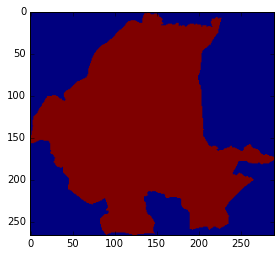

In [23]:
print(fires[-4])
imshow(fires[-4].img)

In [ ]:
# A historical fire is a tuple of (Blob(Pixels), )

In [ ]:
# Load in ignition data (does this have fire perims as well?)

In [24]:
import fiona
from shapely.geometry import Polygon as Poly
from shapely.geometry import MultiPolygon as MPoly
from shapely.geometry import shape

In [32]:
path_to_shp = "F:/DATA/FotF/syphard_ignitions/Final_Data_spatial.shp"
f_ign = fiona.open(path_to_shp)

In [33]:
len(f_ign)

2420

In [34]:
ign = [i for i in f_ign]

In [36]:
ign

[{'geometry': {'coordinates': (547431.2467037264, 3630522.250938968),
   'type': 'Point'},
  'id': '0',
  'properties': OrderedDict([('REPREG', '05'),
               ('REPUNIT', '02'),
               ('FIRENO', '002'),
               ('DIST', '54'),
               ('ST_CAUSE', '9'),
               ('GEN_CAUSE', '0'),
               ('SP_CAUSE', '23'),
               ('CL_PEOPLE', '4'),
               ('SIZECLASS', 'A'),
               ('TOT_ACR', '.1'),
               ('FS_ACR', '.1'),
               ('FSP_ACR', '.0'),
               ('NFS_ACR', '.0'),
               ('VEG_TYPE', '14'),
               ('NF_ASPECT', 'E'),
               ('TOPOG', None),
               ('FMZ_CODE', '3'),
               ('WXSTA', '45704'),
               ('FUEL_MDL', 'C'),
               ('INTENS', '1'),
               ('INTEN_SRC', 'FR'),
               ('LAT', '324842'),
               ('LON', '1162936'),
               ('TWNSP', '0160S'),
               ('RANGE', '0050E'),
               ('SECTION_', '